# 4442 Group Project #
## Stock Market Forecasting 5 Major Blue Chip Stocks Using Time Series Analysis ##
** Ian Borwick ** <br>
** Lucas Fraulin ** <br>
** Benjamin Tilden 250959344 ** <br>

### What is the stock market? ###

Add a description here

### What is ARIMA ###
ARIMA - Autoregression Integrated Moving Average

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Load all libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

import os
import warnings


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import sklearn.metrics as metrics

plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Get and process our data

In [2]:
# Create a date parser
dateParser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
appleData = pd.read_csv("aapl.us.txt", sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateParser).fillna(0)

<ipython-input-2-f96aad3c73e5>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateParser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


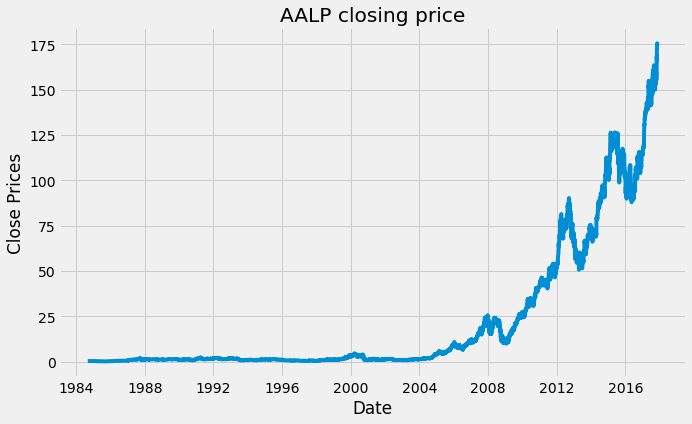

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(appleData['Close'])
plt.title('AALP closing price')
plt.show()

The below graph is a kernal density estimate plot. This is analagous to a histogram and represents the data using a continuous probability density curve.

<AxesSubplot:ylabel='Density'>

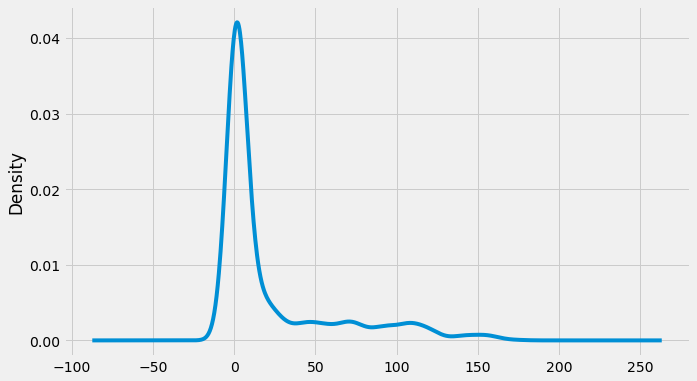

In [4]:
appleData.Close.plot(kind='kde')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise. <br>

These components are defined as follows:<br>

* **Level**: The average value in the series.<br>

* **Trend**: The increasing or decreasing value in the series.<br>

* **Seasonality**: The repeating short-term cycle in the series.<br>

* **Noise**: The random variation in the series.<br>

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.<br>

**ADF (Augmented Dickey-Fuller) Test**<br>

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:<br>

Null Hypothesis: The series has a unit root (value of a =1)<br>

Alternate Hypothesis: The series has no unit root.<br>

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.<br>

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.<br>

**So let's check for stationarity**:<br>

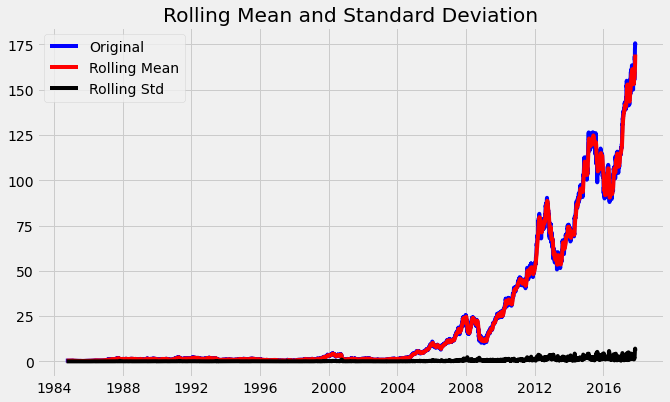

Results of dickey fuller test
Test Statistics                   4.373924
p-value                           1.000000
No. of lags used                 37.000000
Number of observations used    8326.000000
critical value (1%)              -3.431136
critical value (5%)              -2.861887
critical value (10%)             -2.566955
dtype: float64


In [5]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(appleData.Close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<ipython-input-6-8beb5686e569>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(appleData.Close, model='multiplicative', freq = 30)


<Figure size 720x432 with 0 Axes>

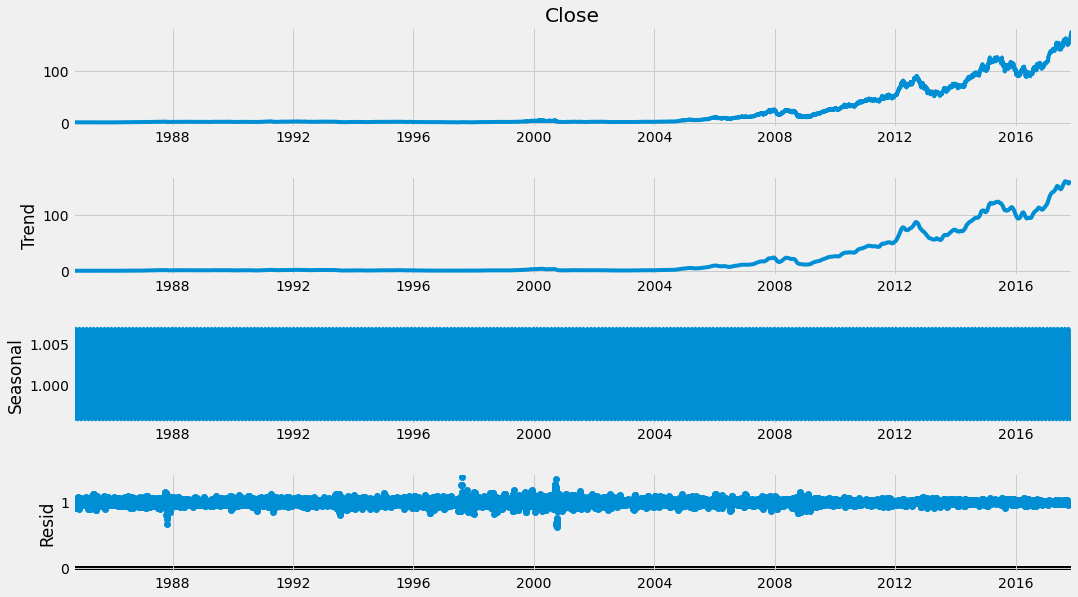

In [6]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(appleData.Close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


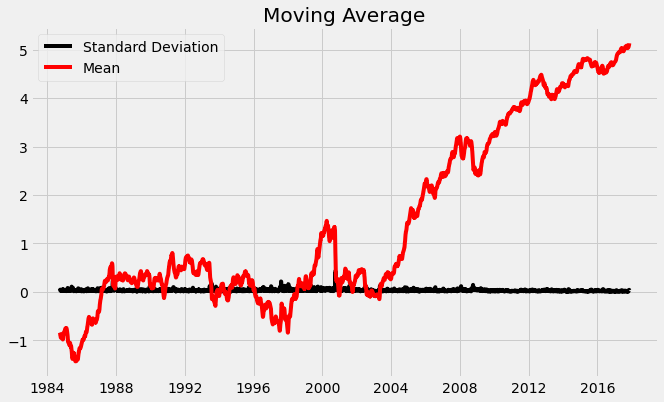

In [7]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(appleData.Close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

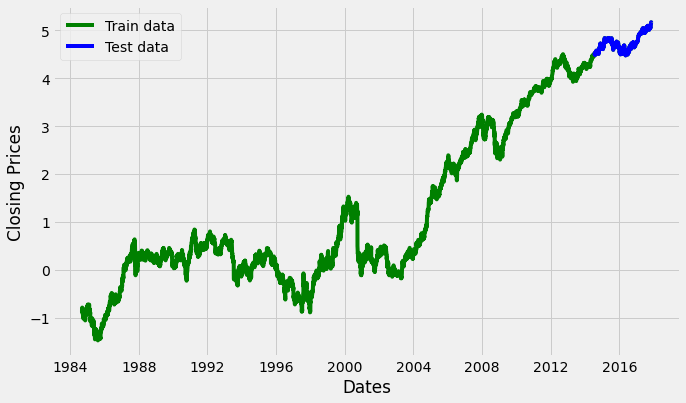

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-31377.404, Time=0.79 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-31375.594, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-31375.597, Time=1.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-31375.178, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-31373.598, Time=1.74 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.981 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7524
Model:               SARIMAX(0, 1, 0)   Log Likelihood               15690.702
Date:                Wed, 10 Mar 2021   AIC                         -31377.404
Time:                        17:01:41   BIC                         -31363.553
Sample:                             0   HQIC                        -31372.648
                               - 7524                             

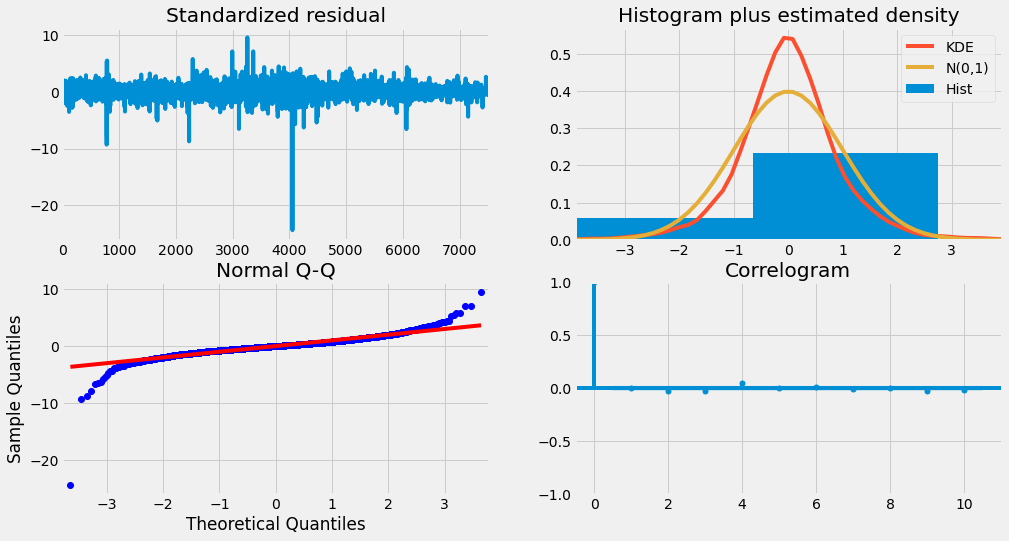

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

So how to interpret the plot diagnostics?

* **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

* **Top Right**: The density plot suggest normal distribution with mean zero.

* **Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.

Next, create an ARIMA model with provided optimal parameters p, d and q.

In [10]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

F:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will b

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 7523
Model:                 ARIMA(1, 1, 2)   Log Likelihood               15693.022
Method:                       css-mle   S.D. of innovations              0.030
Date:                Wed, 10 Mar 2021   AIC                         -31376.043
Time:                        17:01:43   BIC                         -31341.415
Sample:                             1   HQIC                        -31364.154
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      2.109      0.035    5.04e-05       0.001
ar.L1.D.Close     0.2385      0.206      1.158      0.247      -0.165       0.642
ma.L1.D.Close    -0.2340      0.206     

Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [11]:
# Forecast
fc, se, conf = fitted.forecast(837, alpha=0.05)  # 95% conf

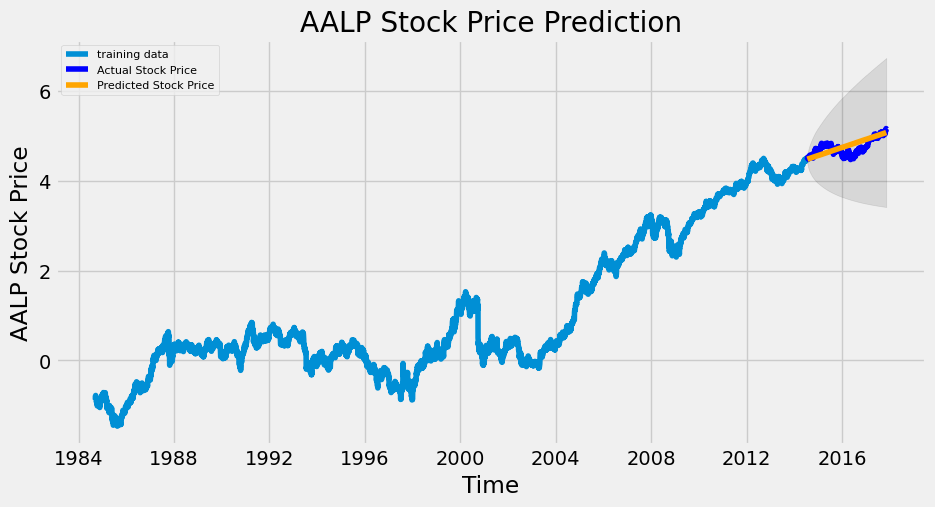

In [12]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AALP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AALP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Results

Mertics Meaning

    diff_pred: difference between the predicted current point and one before it
    diff_true: difference between true current point and one before it
    sign_pred: positive or negative sign of the difference for prediction
    sign_true: positive or negative sign of the difference for true value
    is_correct: 1 if sign_pred == sign_true, otherwise 0
    is_incorrect: 0 if sign_pred == sign_true, otherwise 1
    is_predicted: 1 if the model has made a valid prediction 0 if not (used for confidence levels)
    result: the loss resulting from the predicted sign applied to the actual value

In [13]:
#make dataframe thats useful for metrics
def makeDF(yPred, yTrue):
    y_true = pd.DataFrame(yTrue)
    y_pred = pd.DataFrame(yPred)
    
    df = pd.concat([y_pred, y_true],axis=1)
    df.columns = ['y_pred', 'y_true']

    df['diff_pred'] = df.y_pred.diff()
    df['diff_true'] = df.y_true.diff()
    df['sign_pred'] = df.diff_pred.apply(np.sign)
    df['sign_true'] = df.diff_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred *df.sign_true >0, 'is_correct'] = 1
    df['is_incorrect'] = 0
    df.loc[df.sign_pred *df.sign_true <0, 'is_incorrect'] = 1
    df['is_predicted'] = df.is_correct +df.is_incorrect
    df['result'] = df.sign_pred * df.y_true
    return df

df = makeDF(fc_series,test_data)
print(df.dropna().tail())




              y_pred    y_true  diff_pred  diff_true  sign_pred  sign_true  \
Date                                                                         
2017-11-06  5.077365  5.156927   0.000712   0.010130        1.0        1.0   
2017-11-07  5.078078  5.160089   0.000712   0.003163        1.0        1.0   
2017-11-08  5.078790  5.168266   0.000712   0.008176        1.0        1.0   
2017-11-09  5.079502  5.166214   0.000712  -0.002052        1.0       -1.0   
2017-11-10  5.080215  5.162898   0.000712  -0.003315        1.0       -1.0   

            is_correct  is_incorrect  is_predicted    result  
Date                                                          
2017-11-06           1             0             1  5.156927  
2017-11-07           1             0             1  5.160089  
2017-11-08           1             0             1  5.168266  
2017-11-09           0             1             1  5.166214  
2017-11-10           0             1             1  5.162898  


Explaining the metrics 

    accuracy: percent of predictions that were directionally correct
    edge: expected value of prediction over a sufficentley large enough set
    noise: estimates how dramatically the models prediction vary from one day to the next
    
    yTrueChange: the average magnitude of change in y_true
    yPredChange: the average magnitude of change in y_pred
    predictionCalibration: a ratio of the magnitudes of predictions vs actual
    capture_ratio: ratio of the edge divided by yTrueChange (100 means that the predicted directionality is perfect)
    
    edgeLong: edge for only long signals
    edgeShort: edge for only short signals
    edgeWin: edge for winners
    edgeLose: edge for lossers

In [14]:
#metrics to get accuracy, edge, and noise
def calcScores(df):
    scores = pd.Series(dtype = 'float64')
    
    #building block metrics
    scores.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scores.loc['edge'] = df.result.mean()
    scores.loc['noise'] = df.y_pred.diff().abs().mean()
    
    #metrics
    scores.loc['yTrueChange'] = df.y_true.abs().mean()
    scores.loc['yPredChange'] = df.y_pred.abs().mean()
    scores.loc['predictionCalibration'] = scores.loc['yPredChange']/scores.loc['yTrueChange']
    scores.loc['captureRatio'] = scores.loc['edge']/scores.loc['yTrueChange']*100
    
    #subset prediction metrics
    scores.loc['edgeLong'] = df[df.sign_pred == 1].result.mean()-df.y_true.mean()
    scores.loc['edgeShort'] = df[df.sign_pred == -1].result.mean()-df.y_true.mean()
    scores.loc['edgeWin'] = df[df.is_correct ==1].result.mean() - df.y_true.mean()
    scores.loc['edgeLose'] = df[df.is_incorrect ==1].result.mean() - df.y_true.mean()
    
    return scores
scores = calcScores(df);
print(scores)

accuracy                  52.821128
edge                       4.746279
noise                      0.000712
yTrueChange                4.745959
yPredChange                4.782466
predictionCalibration      1.007692
captureRatio             100.006741
edgeLong                   0.000320
edgeShort                       NaN
edgeWin                    0.007243
edgeLose                  -0.006414
dtype: float64


In [15]:
#metrics over time
def scoresByYear(df):
    df['year'] = df.index.get_level_values('Date').year
    return df.groupby('year').apply(calcScores).T
print(scoresByYear(df))

year                         2014        2015        2016        2017
accuracy                53.982301   48.412698   53.200000   56.880734
edge                     4.589455    4.739679    4.621567    4.980080
noise                    0.000710    0.000712    0.000712    0.000712
yTrueChange              4.588490    4.739679    4.621567    4.980080
yPredChange              4.525321    4.656029    4.835533    5.002928
predictionCalibration    0.986233    0.982351    1.046297    1.004588
captureRatio           100.021026  100.000000  100.000000  100.000000
edgeLong                 0.000965    0.000000    0.000000    0.000000
edgeShort                     NaN         NaN         NaN         NaN
edgeWin                  0.001160    0.003854    0.003819    0.000184
edgeLose                 0.001644   -0.003617   -0.004802   -0.000243


Parameter tuning for ols regression
Parameter tuning for LASSO regression
Parameter tuning for elastic net regression
Parameter tuning for k-nearest neighbours regression
Parameter tuning for random forest regression
                       lr_train_scores  lr_test_scores  ls_train_scores  \
accuracy                     51.253636       52.821128        51.253636   
edge                          1.105895        4.746279         1.105895   
noise                         0.000377        0.000376         0.000465   
yTrueChange                   1.320465        4.745959         1.320465   
yPredChange                   1.416016        2.993827         1.223149   
predictionCalibration         1.072362        0.630816         0.926302   
captureRatio                 83.750429      100.006741        83.750429   
edgeLong                      0.000263        0.000320         0.000263   
edgeShort                          NaN             NaN              NaN   
edgeWin                       0.0

<ipython-input-14-0cf1e76b1e6a>:6: RuntimeWarning: invalid value encountered in double_scalars
  scores.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
<ipython-input-14-0cf1e76b1e6a>:6: RuntimeWarning: invalid value encountered in double_scalars
  scores.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100


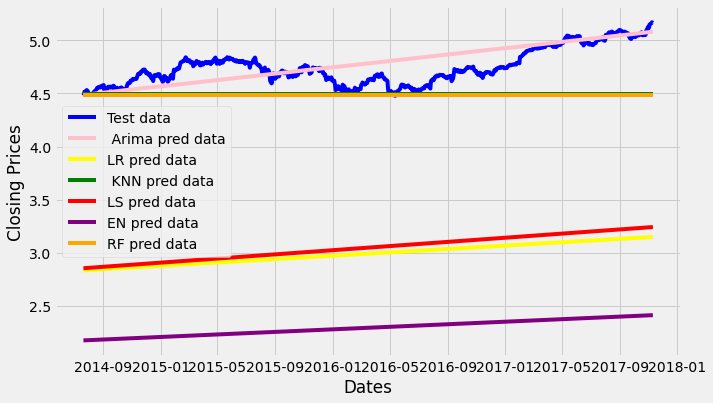

In [20]:
#comparing to different models
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OneHotEncoder
import datetime as dt

#preprocess and split data
xTrain = np.array(train_data.index.map(dt.datetime.toordinal)).reshape(-1,1)
xTrain =pd.DataFrame(xTrain)

xTest = np.array(test_data.index.map(dt.datetime.toordinal)).reshape(-1,1)
xTest =pd.DataFrame(xTest)

yTrain = train_data.values
yTrain =pd.DataFrame(yTrain)

yTest = test_data.values
yTest =pd.DataFrame(yTest)

mms = MinMaxScaler(feature_range=(0,1))
tscv = TimeSeriesSplit(n_splits=2)


#models to test
ml_pipe_ols = Pipeline([('scale', mms), ('ols', LinearRegression())])
ml_pipe_lasso = Pipeline([('scale', mms), ('lasso', Lasso(alpha=0.0001, max_iter=20000))])
ml_pipe_enet = Pipeline([('scale', mms), ('enet', ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000))])
ml_pipe_knn = Pipeline([('scale', mms), ('knn', KNeighborsRegressor(
        n_neighbors=80, weights='uniform', algorithm='auto', leaf_size=30, p=2
        , metric='minkowski', metric_params=None, n_jobs=None))])
ml_pipe_rf = Pipeline([('scale', mms), ('rf', RandomForestRegressor(n_estimators='warn', criterion='mse', 
                       max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                       max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                       min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
                       random_state=None, verbose=0, warm_start=False))])

                                          
#Parameter Tuning                                 
param_grid_ols = [{'ols__fit_intercept': [True, False]}]
param_grid_lasso = [{'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}]
param_grid_enet = {
       'enet__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
        , 'enet__l1_ratio': [0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 1]
        }
param_grid_knn = [{
        'knn__n_neighbors': [10, 20, 40]}]
                                          
param_grid_rf = [{
        'rf__n_estimators': [5, 10],
        'rf__max_features': ['auto', 'sqrt', 'log2'],
        'rf__max_depth' : [2,4,8],
        'rf__min_samples_leaf': [5],
        'rf__min_samples_split': [10],
        'rf__criterion' :['mse', 'mae']}]
                                         
                                          
#linear regression                                      
gs_ols = GridSearchCV(estimator=ml_pipe_ols, param_grid=param_grid_ols, scoring='r2', cv=tscv, return_train_score=True)
print("Parameter tuning for ols regression")
gs_ols.fit(xTrain, yTrain)
gs_ols.best_params_

lr_train = gs_ols.predict(xTrain)
lr_test = gs_ols.predict(xTest)


#Lasso Regression 
gs_lasso = GridSearchCV(estimator=ml_pipe_lasso, param_grid=param_grid_lasso, scoring=None, cv=tscv, return_train_score=True)
print("Parameter tuning for LASSO regression")
gs_lasso.fit(xTrain, yTrain)
gs_lasso.best_params_
    
ls_train = pd.Series(gs_lasso.predict(xTrain))
ls_test = pd.Series(gs_lasso.predict(xTest))

#Elastic Net
gs_enet = GridSearchCV(estimator=ml_pipe_enet, param_grid=param_grid_enet, scoring=None, cv=tscv, return_train_score=True)
print("Parameter tuning for elastic net regression")
gs_enet.fit(xTrain, yTrain)
gs_enet.best_params_
    
en_train = pd.Series(gs_enet.predict(xTrain))
en_test = pd.Series(gs_enet.predict(xTest))

                                          
#KNN 
gs_knn = GridSearchCV(estimator=ml_pipe_knn, param_grid=param_grid_knn, scoring=None, cv=tscv, return_train_score=True)
print("Parameter tuning for k-nearest neighbours regression")
gs_knn.fit(xTrain.astype(float), yTrain.values.ravel().astype(float))
gs_knn.best_params_

knn_train = pd.Series(gs_knn.predict(xTrain))
knn_test = pd.Series(gs_knn.predict(xTest))
                                          
#Random Forest Regressor
    
gs_rf = GridSearchCV(estimator=ml_pipe_rf, param_grid=param_grid_rf, scoring=None, cv=tscv, return_train_score=True)
print("Parameter tuning for random forest regression")
gs_rf.fit(xTrain, yTrain.values.ravel())
gs_rf.best_params_
    
rf_train = pd.Series(gs_rf.predict(xTrain))
rf_test = pd.Series(gs_rf.predict(xTest))

                                          
#get data frames
lr_train_df = makeDF(lr_train, yTrain)
lr_test_df = makeDF(lr_test, yTest)

ls_train_df = makeDF(ls_train, yTrain)
ls_test_df = makeDF(ls_test, yTest)

en_train_df = makeDF(en_train, yTrain)
en_test_df = makeDF(en_test, yTest)

knn_train_df = makeDF(knn_train, yTrain)
knn_test_df = makeDF(knn_test, yTest)

rf_train_df = makeDF(rf_train, yTrain)
rf_test_df = makeDF(rf_test, yTest)


#Get metrics for each df
lr_train_scores = calcScores(lr_train_df)
lr_train_scores.name = 'lr_train_scores'
lr_test_scores = calcScores(lr_test_df)
lr_test_scores.name = 'lr_test_scores'

ls_train_scores = calcScores(ls_train_df)
ls_train_scores.name = 'ls_train_scores'
ls_test_scores = calcScores(ls_test_df)
ls_test_scores.name = 'ls_test_scores'

en_train_scores = calcScores(en_train_df)
en_train_scores.name = 'en_train_scores'
en_test_scores = calcScores(en_test_df)
en_test_scores.name = 'en_test_scores'

knn_train_scores = calcScores(knn_train_df)
knn_train_scores.name = 'knn_train_scores'
knn_test_scores = calcScores(knn_test_df)
knn_test_scores.name = 'knn_test_scores'

rf_train_scores = calcScores(rf_train_df)
rf_train_scores.name = 'rf_train_scores'
rf_test_scores = calcScores(rf_test_df)
rf_test_scores.name = 'rf_test_scores'

#print all
#print(pd.concat([lr_train_scores, lr_test_scores, 
                 ls_train_scores,  ls_test_scores,
                 en_train_scores, en_test_scores,
                 knn_train_scores, knn_test_scores,
                 rf_train_scores,rf_test_scores],
                axis = 1))


#make a graph to show other models accuracy
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
#plt.plot(train_data.index, yTrain, 'green', label='Train data')
plt.plot(test_data.index, np.array(yTest), 'blue', label='Test data')
plt.plot(test_data.index, fc_series, 'pink', label=' Arima pred data')
plt.plot(test_data.index, lr_test, 'yellow', label='LR pred data')
plt.plot(test_data.index, knn_test, 'green', label=' KNN pred data')
plt.plot(test_data.index, ls_test, 'red', label='LS pred data')
plt.plot(test_data.index, en_test, 'purple', label='EN pred data')
plt.plot(test_data.index, rf_test, 'orange', label='RF pred data')
plt.legend()


#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also

In [26]:
# report performance
mse = mean_squared_error(test_data, fc)
#mse = metrics.mean_squared_error(test_data,fc)
print('MSE: '+str(mse))

mae = mean_absolute_error(test_data, fc)
#mae1 = metrics.mean_absolute_error(test_data,fc)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

medAe =  metrics.median_absolute_error(test_data,fc)
print('MedAE: ' + str(medAe))

rsq = metrics.r2_score(test_data, fc)
print('RSQ: '+ str(rsq))

explained_varience = metrics.explained_variance_score(test_data,fc)
print('Explained Varience: '+ str(explained_varience))


MSE: 0.02126500033139465
MAE: 0.11625441275970691
RMSE: 0.14582523900681477
MAPE: 0.02483168791782673
MedAE: 0.10909125128061437
RSQ: 0.24759498471933705
Explained Varience: 0.29475325107087214


Around 2.5% MAPE implies the model is about 97.5% accurate in predicting the next 15 observations.